# Flatiron School: Use your regression skills to save the Galaxy

### InClass prediction Competition

### 1. Obtaining the Data

In [214]:
# import libraries 
import pandas as pd
import numpy as np
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [215]:
df = pd.read_csv('train.csv')
df.shape

(11703, 13)

In [216]:
df.head()

,Id,NA_Sales,Platform,Year_of_Release,Genre,Publisher,JP_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,0,0.00,PSP,2008.0,Misc,Sony Computer Entertainment,0.06,81.0,49.0,8.3,62.0,SCE Japan Studio,E
1,1,0.72,2600,1982.0,Shooter,Atari,0.00,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.11,XB,2004.0,Action,THQ,0.00,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0.15,X360,2008.0,Fighting,Electronic Arts,0.00,54.0,57.0,6.3,19.0,EA Canada,T
4,4,0.00,DS,2006.0,Action,Namco Bandai Games,0.01,NaN,NaN,NaN,NaN,NaN,NaN


In [217]:
df.duplicated().sum()

0

In [218]:
df = df.drop(['Id', 'Publisher', 'Developer', 'Rating', 'Critic_Count', 'User_Count'], axis=1)

In [219]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11703 entries, 0 to 11702
Data columns (total 7 columns):
NA_Sales           11703 non-null float64
Platform           11703 non-null object
Year_of_Release    11520 non-null float64
Genre              11701 non-null object
JP_Sales           11703 non-null float64
Critic_Score       5697 non-null float64
User_Score         7011 non-null object
dtypes: float64(4), object(3)
memory usage: 640.1+ KB


### 2. Preprocessing the Data

**2.1. Dropping Records with missing values**

In [220]:
# handling NaN records in genre_column
df = df.dropna(axis=0, subset=['Year_of_Release', 'Genre'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11518 entries, 0 to 11702
Data columns (total 7 columns):
NA_Sales           11518 non-null float64
Platform           11518 non-null object
Year_of_Release    11518 non-null float64
Genre              11518 non-null object
JP_Sales           11518 non-null float64
Critic_Score       5597 non-null float64
User_Score         6893 non-null object
dtypes: float64(4), object(3)
memory usage: 719.9+ KB


**2.2. Handling `Platform` column**

In [222]:
df.Platform.unique()

array(['PSP', '2600', 'XB', 'X360', 'DS', 'PS2', 'Wii', 'PS3', '3DS',
       'PS', 'XOne', 'SNES', 'WiiU', 'GBA', 'PS4', 'PC', 'PSV', 'SAT',
       'GC', 'NES', 'N64', 'GEN', 'PCFX', 'GB', 'DC', 'TG16', 'NG', 'SCD',
       'WS', '3DO', 'GG'], dtype=object)

In [224]:
# check Platform_column for main platforms and create interim columns
df['Nintendo']    = df['Platform'].str.contains('DS', regex=True)
df['Playstation'] = df['Platform'].str.contains('PS', regex=True)
df['X_Box']       = df['Platform'].str.contains('X(\d|\w)', regex=True)
df['Wii']         = df['Platform'].str.contains('Wii', regex=True)
df['PC']          = df['Platform'].str.contains('PC', regex=True)

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x1a2d755f28>>
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/xgboost/core.py", line 482, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  after removing the cwd from sys.path.


In [225]:
# define function ...
def label_platform(row):
    if row['Nintendo'] == True:
        return 'Nintendo'
    if row['Playstation'] == True:
        return 'Playstation'
    if row['X_Box'] == True:
        return 'X_Box'
    if row['Wii'] == True:
        return 'Wii'
    if row['PC'] == True:
        return 'PC'
    return 'Other'

# ... and apply this function for creating a new column
df['platform_groups'] = df.apply(lambda row: label_platform(row), axis=1)

# dropping interim columns
df = df.drop(['Platform', 'Nintendo', 'Playstation', 'X_Box', 'Wii', 'PC'], axis=1)

df.head()

,NA_Sales,Year_of_Release,Genre,JP_Sales,Critic_Score,User_Score,platform_groups
0,0.00,2008.0,Misc,0.06,81.0,8.3,Playstation
1,0.72,1982.0,Shooter,0.00,NaN,NaN,Other
2,0.11,2004.0,Action,0.00,NaN,NaN,X_Box
3,0.15,2008.0,Fighting,0.00,54.0,6.3,X_Box
4,0.00,2006.0,Action,0.01,NaN,NaN,Nintendo


**2.4. Handling `Year_of_release` column**

In [226]:
df['Year_of_Release'] = df['Year_of_Release'].astype('int64')
df['Year_of_Release'] = pd.to_datetime(df['Year_of_Release'], format="%Y").dt.year

In [227]:
df.head()

,NA_Sales,Year_of_Release,Genre,JP_Sales,Critic_Score,User_Score,platform_groups
0,0.00,2008,Misc,0.06,81.0,8.3,Playstation
1,0.72,1982,Shooter,0.00,NaN,NaN,Other
2,0.11,2004,Action,0.00,NaN,NaN,X_Box
3,0.15,2008,Fighting,0.00,54.0,6.3,X_Box
4,0.00,2006,Action,0.01,NaN,NaN,Nintendo


In [228]:
#df.Year_of_Release.value_counts()

In [229]:
#df.drop(df[df.Year_of_Release < 2000].index, axis=0, inplace=True)
#df.Year_of_Release.value_counts()

**2.3. Handling `User_Score` column**

In [230]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11518 entries, 0 to 11702
Data columns (total 7 columns):
NA_Sales           11518 non-null float64
Year_of_Release    11518 non-null int64
Genre              11518 non-null object
JP_Sales           11518 non-null float64
Critic_Score       5597 non-null float64
User_Score         6893 non-null object
platform_groups    11518 non-null object
dtypes: float64(3), int64(1), object(3)
memory usage: 719.9+ KB


In [231]:
df.User_Score.unique()

array(['8.3', nan, '6.3', 'tbd', '7.7', '2.8', '8.2', '9', '4.3', '7.2',
       '8.5', '7.6', '7.5', '8.1', '6.1', '7', '6.7', '7.4', '7.9', '5.4',
       '7.8', '5.2', '8.6', '4', '5', '8.7', '6.8', '4.1', '6.4', '6.6',
       '9.3', '7.3', '5.7', '4.2', '2.7', '3.8', '3', '8', '6.2', '8.8',
       '4.4', '7.1', '3.6', '5.5', '4.5', '8.4', '5.9', '6', '5.3', '0.5',
       '8.9', '6.5', '3.2', '9.1', '5.8', '5.6', '4.9', '6.9', '2.4',
       '9.5', '3.7', '3.3', '3.9', '2.6', '2.9', '9.2', '1.8', '4.6',
       '3.4', '4.8', '4.7', '5.1', '9.4', '3.1', '2.5', '3.5', '2.2',
       '2.1', '1.9', '9.7', '1.4', '1.7', '0', '0.3', '1.5', '1', '9.6',
       '1.6', '1.2', '0.9', '0.7', '0.6', '2', '2.3', '1.3', '0.2'],
      dtype=object)

In [232]:
len(df[df['User_Score'] == 'tbd'])

1646

In [233]:
# replace 'tbd'
df['User_Score'].replace(to_replace='tbd', value=np.nan, inplace=True)

# convert string values into numeric values
df['User_Score'] = pd.to_numeric(df['User_Score'])

df.User_Score.describe()

count    5247.000000
mean        7.126739
std         1.489370
min         0.000000
25%         6.400000
50%         7.500000
75%         8.200000
max         9.700000
Name: User_Score, dtype: float64

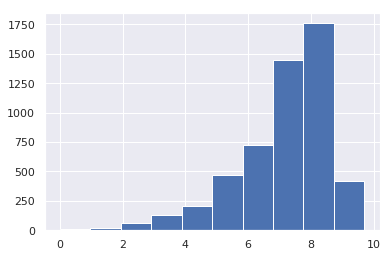

In [234]:
df.User_Score.hist();

In [235]:
# How many NaN's are we up against?
round(df['User_Score'].isna().sum()/len(df), 3)

0.544

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11518 entries, 0 to 11702
Data columns (total 9 columns):
NA_Sales           11518 non-null float64
Year_of_Release    11518 non-null int64
Genre              11518 non-null object
JP_Sales           11518 non-null float64
Critic_Score       5597 non-null float64
Critic_Count       5597 non-null float64
User_Score         5247 non-null float64
User_Count         5247 non-null float64
platform_groups    11518 non-null object
dtypes: float64(6), int64(1), object(2)
memory usage: 899.8+ KB


In [143]:
# filter out sub_df to work with
sub_df = df[['NA_Sales', 'Year_of_Release', 'JP_Sales', 'Critic_Score', 'User_Score']]

# convert string values in into categorical values
#sub_df['Genre'] = sub_df['Genre'].astype('category')
#sub_df['platform_groups'] = sub_df['platform_groups'].astype('category')

In [144]:
sub_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11518 entries, 0 to 11702
Data columns (total 5 columns):
NA_Sales           11518 non-null float64
Year_of_Release    11518 non-null int64
JP_Sales           11518 non-null float64
Critic_Score       5597 non-null float64
User_Score         5247 non-null float64
dtypes: float64(4), int64(1)
memory usage: 539.9 KB


In [145]:
# split datasets
train_data = sub_df[sub_df['User_Score'].notnull()]
test_data  = sub_df[sub_df['User_Score'].isnull()]

# define X for both datasets
X_train = train_data.drop('User_Score', axis=1)
X_test  = test_data.drop('User_Score', axis=1)

# define y for train dataset
y_train = train_data['User_Score']

# create dummy variables of all categorical features
#X_train = pd.get_dummies(X_train)

X_train.head()

,NA_Sales,Year_of_Release,JP_Sales,Critic_Score
0,0.00,2008,0.06,81.0
3,0.15,2008,0.00,54.0
7,0.10,2005,1.12,59.0
10,0.02,2005,0.00,33.0
12,0.21,2003,0.00,74.0


In [146]:
# create a baseline
booster = xgb.XGBRegressor()

# instantiate xgboost with best parameters
booster = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.2, learning_rate=0.01, 
                           max_depth=7, n_estimators=200, random_state=4)

# fit model to training data
booster.fit(X_train, y_train)

# making predictions
y_test = booster.predict(X_test)

In [147]:
# preparing y_test
y_test = pd.DataFrame(y_test)
y_test.columns = ['User_Score']
print(y_test.shape)
y_test.head(2)

(6271, 1)


,User_Score
0,5.465840
1,6.227887


In [148]:
# preparing X_test
print(X_test.shape)
X_test.head(2)

(6271, 4)


,NA_Sales,Year_of_Release,JP_Sales,Critic_Score
1,0.72,1982,0.0,NaN
2,0.11,2004,0.0,NaN


In [149]:
# make the index of X_test to an own dataframe
prelim_index = pd.DataFrame(X_test.index)
prelim_index.columns = ['prelim']

# ... and concat this dataframe with y_test
y_test = pd.concat([y_test, prelim_index], axis=1)
y_test.set_index(['prelim'], inplace=True)

# finally combine the new test data
test_data = pd.concat([X_test, y_test], axis=1)

In [150]:
# combine train and test data back to a new sub df
sub_df_new = pd.concat([test_data, train_data], axis=0)

print(sub_df_new.shape)
sub_df_new.head(2)

(11518, 5)


,NA_Sales,Year_of_Release,JP_Sales,Critic_Score,User_Score
1,0.72,1982,0.0,NaN,5.465840
2,0.11,2004,0.0,NaN,6.227887


In [151]:
sub_df_new['User_Score'].isna().sum()

0

In [152]:
# drop duplicate columns in original dataframe before concatening 
df = df.drop(['NA_Sales', 'Year_of_Release', 'JP_Sales', 'Critic_Score', 'User_Score'], axis=1)

# concatenate back to complete dataframe
df = pd.concat([sub_df_new, df], axis=1)

print(df.shape)
df.head(2)

(11518, 9)


,NA_Sales,Year_of_Release,JP_Sales,Critic_Score,User_Score,Genre,Critic_Count,User_Count,platform_groups
0,0.00,2008,0.06,81.0,8.30000,Misc,49.0,62.0,Playstation
1,0.72,1982,0.00,NaN,5.46584,Shooter,NaN,NaN,Other


In [154]:
df = df.drop(['User_Count'], axis=1)

**2.3. Handling `Critic_Score` column**

In [155]:
# filter out sub_df to work with
sub_df = df[['NA_Sales', 'Year_of_Release', 'JP_Sales', 'Critic_Score', 'User_Score']]

In [156]:
# split datasets
train_data = sub_df[sub_df['Critic_Score'].notnull()]
test_data  = sub_df[sub_df['Critic_Score'].isnull()]

# define X for both datasets
X_train = train_data.drop('Critic_Score', axis=1)
X_test  = test_data.drop('Critic_Score', axis=1)

# define y for train dataset
y_train = train_data['Critic_Score']

# create dummy variables of all categorical features
#X_train = pd.get_dummies(X_train)

X_train.head()

,NA_Sales,Year_of_Release,JP_Sales,User_Score
0,0.00,2008,0.06,8.300000
3,0.15,2008,0.00,6.300000
7,0.10,2005,1.12,7.700000
9,0.10,2008,0.00,5.415651
10,0.02,2005,0.00,2.800000


In [157]:
# create a baseline
booster = xgb.XGBRegressor()

# instantiate xgboost with best parameters
booster = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.2, learning_rate=0.01, 
                           max_depth=7, n_estimators=200, random_state=4)

# fit model to training data
booster.fit(X_train, y_train)

# making predictions
y_test = booster.predict(X_test)

In [158]:
# preparing y_test
y_test = pd.DataFrame(y_test)
y_test.columns = ['Critic_Score']
print(y_test.shape)
y_test.head(2)

(5921, 1)


,Critic_Score
0,53.273129
1,54.381477


In [159]:
# preparing X_test
print(X_test.shape)
X_test.head(2)

(5921, 4)


,NA_Sales,Year_of_Release,JP_Sales,User_Score
1,0.72,1982,0.0,5.465840
2,0.11,2004,0.0,6.227887


In [160]:
# make the index of X_test to an own dataframe
prelim_index = pd.DataFrame(X_test.index)
prelim_index.columns = ['prelim']

# ... and concat this dataframe with y_test
y_test = pd.concat([y_test, prelim_index], axis=1)
y_test.set_index(['prelim'], inplace=True)

# finally combine the new test data
test_data = pd.concat([X_test, y_test], axis=1)

In [161]:
# combine train and test data back to a new sub df
sub_df_new = pd.concat([test_data, train_data], axis=0)

print(sub_df_new.shape)
sub_df_new.head(2)

(11518, 5)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,Critic_Score,JP_Sales,NA_Sales,User_Score,Year_of_Release
1,53.273129,0.0,0.72,5.465840,1982
2,54.381477,0.0,0.11,6.227887,2004


In [162]:
sub_df_new['Critic_Score'].isna().sum()

0

In [163]:
# drop duplicate columns in original dataframe before concatening 
df = df.drop(['Critic_Score', 'JP_Sales', 'NA_Sales', 'User_Score', 'Year_of_Release'], axis=1)

# concatenate back to complete dataframe
df = pd.concat([sub_df_new, df], axis=1)

print(df.shape)
df.head(2)

(11518, 8)


,Critic_Score,JP_Sales,NA_Sales,User_Score,Year_of_Release,Genre,Critic_Count,platform_groups
0,81.000000,0.06,0.00,8.30000,2008,Misc,49.0,Playstation
1,53.273129,0.00,0.72,5.46584,1982,Shooter,NaN,Other


In [164]:
df = df.drop(['Critic_Count'], axis=1)

In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11518 entries, 0 to 11702
Data columns (total 7 columns):
Critic_Score       11518 non-null float64
JP_Sales           11518 non-null float64
NA_Sales           11518 non-null float64
User_Score         11518 non-null float64
Year_of_Release    11518 non-null int64
Genre              11518 non-null object
platform_groups    11518 non-null object
dtypes: float64(4), int64(1), object(2)
memory usage: 719.9+ KB


**2.5. Handling `Rating` column**

In [166]:
#df.Rating.value_counts()

In [167]:
#df.drop(df[df.Rating == 'RP'].index, axis=0, inplace=True)
#df.Rating.value_counts()

In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11518 entries, 0 to 11702
Data columns (total 7 columns):
Critic_Score       11518 non-null float64
JP_Sales           11518 non-null float64
NA_Sales           11518 non-null float64
User_Score         11518 non-null float64
Year_of_Release    11518 non-null int64
Genre              11518 non-null object
platform_groups    11518 non-null object
dtypes: float64(4), int64(1), object(2)
memory usage: 719.9+ KB


## 3. Machine Learning

*Preparing Target & Features*

In [169]:
# define our features 
features = df.drop(["NA_Sales"], axis=1)

# define our target
target = df[["NA_Sales"]]

*Recoding Categorical Features*

In [170]:
# convert string values in object columns into categorical values
df['Genre'] = df['Genre'].astype('category')
#df['Rating'] = df['Rating'].astype('category')
df['platform_groups'] = df['platform_groups'].astype('category')

In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11518 entries, 0 to 11702
Data columns (total 7 columns):
Critic_Score       11518 non-null float64
JP_Sales           11518 non-null float64
NA_Sales           11518 non-null float64
User_Score         11518 non-null float64
Year_of_Release    11518 non-null int64
Genre              11518 non-null category
platform_groups    11518 non-null category
dtypes: category(2), float64(4), int64(1)
memory usage: 563.0 KB


In [172]:
# create dummy variables of all categorical features
features = pd.get_dummies(features)

*Train-Test-Split*

In [173]:
# import train_test_split function
from sklearn.model_selection import train_test_split

# split our data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

*Scaling the Data*

In [174]:
# scale data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  """


*XGBoost*

In [175]:
# create a baseline
booster = xgb.XGBRegressor()

In [58]:
from sklearn.model_selection import GridSearchCV

# create Grid
param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

# instantiate the tuned random forest
booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1)

# train the tuned random forest
booster_grid_search.fit(X_train, y_train)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)

{'colsample_bytree': 0.7, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200}


In [176]:
# instantiate xgboost with best parameters
booster = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.2, learning_rate=0.01, 
                           max_depth=7, n_estimators=200, random_state=4)

# train
booster.fit(X_train, y_train)

# predict
y_pred_train = booster.predict(X_train)
y_pred_test  = booster.predict(X_test)

In [177]:
# import metrics
from sklearn.metrics import mean_squared_error, r2_score

RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {round(RMSE, 4)}")

r2 = r2_score(y_test, y_pred_test)
print(f"r2: {round(r2, 4)}")

RMSE: 0.4713
r2: 0.3781


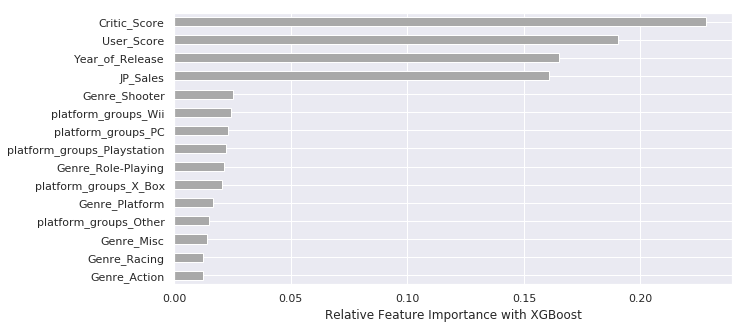

In [178]:
# plot the important features
feat_importances = pd.Series(booster.feature_importances_, index=features.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))
plt.xlabel('Relative Feature Importance with XGBoost');